## Team : Abdelbaki GUIR - Omar MAMACHE - Taqwa MEZAACHE 
### Machine Learning Project 1 : Incremental Learning based on rehearsal and distillation knowledge,


# Incremental Learning Learning for Traffic Sign Recognition

## Project Overview

This project implements an incremental learning system for traffic sign recognition using the German Traffic Sign Recognition Benchmark (GTSRB) dataset. The system addresses catastrophic forgetting—a major challenge in continual learning—through two complementary techniques: memory rehearsal and knowledge distillation.

## The Problem of Catastrophic Forgetting

Neural networks excel at learning new tasks but typically suffer from catastrophic forgetting when trained sequentially on different tasks. When a model learns new information, it tends to overwrite previously acquired knowledge, resulting in significantly degraded performance on earlier tasks.

## Dataset: German Traffic Sign Recognition Benchmark (GTSRB)

The GTSRB dataset contains 43 different classes of traffic signs with varying lighting conditions, perspectives, and occlusions. In this project, these 43 classes are divided into 5 sequential tasks to simulate a real-world scenario where traffic sign recognition systems must incrementally learn new sign categories.

## Solution Architecture

### CNN Model Structure

The model uses a convolutional neural network with:
- Three convolutional layers (32, 64, and 128 filters)
- Batch normalization after each convolutional layer
- Max pooling for dimensionality reduction
- Dropout (0.5) for regularization
- Two fully connected layers (512 units and 43 output classes)

### Memory Replay/Rehearsal

The first technique implemented to combat forgetting is memory replay:

```python
class MemoryBuffer:
    def __init__(self, buffer_size=200):
        self.buffer_size = buffer_size
        self.images = []
        self.labels = []
        
    def update(self, images, labels, per_class=20):
        unique_labels = torch.unique(labels)
        for label in unique_labels:
            indices = torch.where(labels == label)[0]
            selected = indices[:min(per_class, len(indices))]
            
            self.images.extend(images[selected].cpu())
            self.labels.extend(labels[selected].cpu())
            
        # Keep only buffer_size samples
        if len(self.images) > self.buffer_size:
            indices = random.sample(range(len(self.images)), self.buffer_size)
            self.images = [self.images[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]
```

Key characteristics of the replay mechanism:
- Maintains a fixed-size memory buffer (2000 samples)
- Stores a balanced set of examples per class (up to 20 samples per class)
- Randomly selects samples when buffer capacity is exceeded
- Integrates memory samples with current task data during training

### Knowledge Distillation

The second technique is knowledge distillation, which preserves the model's behavior on previously learned tasks:

```python
def distillation_loss(outputs, teacher_outputs, T=2.0):
    soft_targets = nn.functional.softmax(teacher_outputs / T, dim=1)
    soft_prob = nn.functional.log_softmax(outputs / T, dim=1)
    return nn.KLDivLoss(reduction='batchmean')(soft_prob, soft_targets) * (T * T)
```

In the training loop, this is implemented as:

```python
# Add knowledge distillation loss for old tasks
if current_task > 0:
    with torch.no_grad():
        teacher_outputs = old_model(combined_inputs)
    distill_loss = distillation_loss(outputs, teacher_outputs)
    loss = loss + 0.5 * distill_loss  # alpha=0.5 controls KD contribution
```

The distillation process:
1. Creates a copy of the current model as a "teacher" before learning a new task
2. Generates soft probability distributions from the teacher model
3. Encourages the updated model to produce similar outputs to the teacher
4. Balances classification accuracy with preserving knowledge of previous tasks

## Performance Evaluation

The system tracks performance using:
- Task-by-task accuracy matrix showing performance on all tasks after learning each new task
- Forgetting measurements that quantify knowledge degradation
- Visualization tools for both dataset characteristics and model performance

## Results and Insights

The combination of rehearsal and knowledge distillation effectively mitigates catastrophic forgetting. The accuracy matrix and forgetting measurements demonstrate how these techniques help maintain performance on earlier tasks while accommodating new knowledge.

The visualizations reveal:
- How performance evolves across sequential tasks
- Which classes/tasks are most susceptible to forgetting
- The effectiveness of the combined approach compared to using either technique alone

## Applications and Future Work

This approach to continual learning has practical applications in:
- Autonomous vehicles that must adapt to new traffic signs
- Smart city infrastructure with evolving signage regulations
- Any vision system that requires incremental updating

Future work could explore:
- Parameter-efficient fine-tuning to reduce memory requirements
- More sophisticated memory management strategies
- Integration with self-supervised learning for better feature representation


## Importing Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset, Dataset, ConcatDataset
import copy
import random
from torchvision.utils import make_grid
import polars as pl

from data_prep import *
from model import *
from utils import *


import warnings
warnings.filterwarnings('ignore')

## Data Preparation

📊 **GTSRB Dataset (German Traffic Sign Recognition Benchmark)** :

$\bullet$ Purpose: Benchmark for traffic sign recognition systems.

$\bullet$ Content: Over 50,000 images of 43 classes of traffic signs.

$\bullet$ Image Size: Varies, typically resized to 32x32 or 48x48 for training.

$\bullet$ Applications: Widely used in computer vision tasks related to autonomous driving and traffic sign classification.

In [2]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

# Load GTSRB dataset
train_dataset = torchvision.datasets.GTSRB(
    root='./data', split='train', download=True, transform=transform
)

test_dataset = torchvision.datasets.GTSRB(
    root='./data', split='test', download=True, transform=transform
)

# Wrap datasets to add targets attribute
train_dataset = GTSRBWrapper(train_dataset)
test_dataset = GTSRBWrapper(test_dataset)

# Create task splits
train_tasks = create_task_splits(train_dataset, num_tasks=5)
test_tasks = create_task_splits(test_dataset, num_tasks=5)

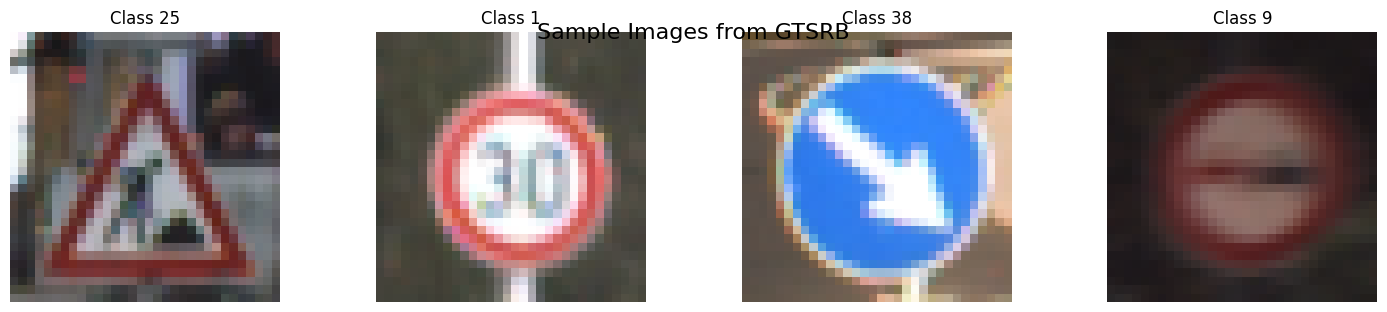

In [8]:
plot_sample_images(train_dataset, num_images=4, classes_per_row=4)

## Moddeling and Learning

As Seen in file **model.py** we will be importing our feature extractor.

In addition we will be defining some training parameters, and initializing The **Memory buffer** for the rehearsal that will be set as **100** for each task !

And we add distillation loss to preserve the model's behavior on previously learned tasks.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = GTSRB_extractor(num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#initialize Buffer Memory
memory = MemoryBuffer(buffer_size=200)  # Store 200 samples

In [18]:
epochs = 15
batch_size = 512

# Results tracking
accuracy_matrix = np.zeros((5, 5))  # Task x Task accuracy matrix

# Incremental learning through tasks
for current_task, train_data in enumerate(train_tasks):
    print(f"Learning task {current_task+1}")
    
    # Initialize old_model for knowledge distillation
    if current_task > 0:  
        old_model = copy.deepcopy(model)
        old_model.eval()
    
    # Create data loader for current task
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get rehearsal data
            if current_task > 0:
                memory_inputs, memory_labels = memory.get_data()
                if memory_inputs is not None:
                    memory_inputs = memory_inputs.to(device)
                    memory_labels = memory_labels.to(device)
                    # Combine current batch with memory samples
                    combined_inputs = torch.cat((inputs, memory_inputs), 0)
                    combined_labels = torch.cat((labels, memory_labels), 0)
                else:
                    combined_inputs, combined_labels = inputs, labels
            else:
                combined_inputs, combined_labels = inputs, labels
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(combined_inputs)
            
            # Classification loss
            loss = criterion(outputs, combined_labels)
            
            # Add knowledge distillation loss for old tasks
            if current_task > 0:
                with torch.no_grad():
                    teacher_outputs = old_model(combined_inputs)
                distill_loss = distillation_loss(outputs, teacher_outputs)
                loss = loss + 0.5 * distill_loss  # alpha=0.5 controls KD contribution
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")
    
    # Update memory buffer with samples from current task
    model.eval()
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            memory.update(inputs, labels)
            break  # Just use one batch to update memory
            
    # Evaluate on all previous tasks
    for task_id, test_data in enumerate(test_tasks[:current_task+1]):
        test_loader = DataLoader(test_data, batch_size=batch_size)
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracy_matrix[current_task, task_id] = accuracy
        print(f"After learning task {current_task+1}, accuracy on task {task_id+1}: {accuracy:.2f}%")

# Calculate forgetting
forgetting = np.zeros(5)
for task_id in range(5):
    max_acc = np.max(accuracy_matrix[:task_id+1, task_id]) if task_id < 4 else accuracy_matrix[task_id, task_id]
    forgetting[task_id] = max_acc - accuracy_matrix[4, task_id]

print("\nForgetting for each task:")
for task_id in range(5):
    print(f"Task {task_id+1}: {forgetting[task_id]:.2f}%")

Learning task 1
Epoch 1, Loss: 2.0802
Epoch 2, Loss: 1.1216
Epoch 3, Loss: 0.4794
Epoch 4, Loss: 0.1728
Epoch 5, Loss: 0.0728
Epoch 6, Loss: 0.0437
Epoch 7, Loss: 0.0216
Epoch 8, Loss: 0.0111
Epoch 9, Loss: 0.0073
Epoch 10, Loss: 0.0052
Epoch 11, Loss: 0.0047
Epoch 12, Loss: 0.0032
Epoch 13, Loss: 0.0022
Epoch 14, Loss: 0.0014
Epoch 15, Loss: 0.0012
After learning task 1, accuracy on task 1: 88.91%
Learning task 2
Epoch 1, Loss: 5.1656
Epoch 2, Loss: 2.1466
Epoch 3, Loss: 1.7681
Epoch 4, Loss: 1.6345
Epoch 5, Loss: 1.5629
Epoch 6, Loss: 1.5213
Epoch 7, Loss: 1.4918
Epoch 8, Loss: 1.4728
Epoch 9, Loss: 1.4563
Epoch 10, Loss: 1.4431
Epoch 11, Loss: 1.4312
Epoch 12, Loss: 1.4217
Epoch 13, Loss: 1.4157
Epoch 14, Loss: 1.4092
Epoch 15, Loss: 1.4044
After learning task 2, accuracy on task 1: 84.13%
After learning task 2, accuracy on task 2: 75.44%
Learning task 3
Epoch 1, Loss: 5.2948
Epoch 2, Loss: 2.6433
Epoch 3, Loss: 1.8420
Epoch 4, Loss: 1.5082
Epoch 5, Loss: 1.3331
Epoch 6, Loss: 1.251

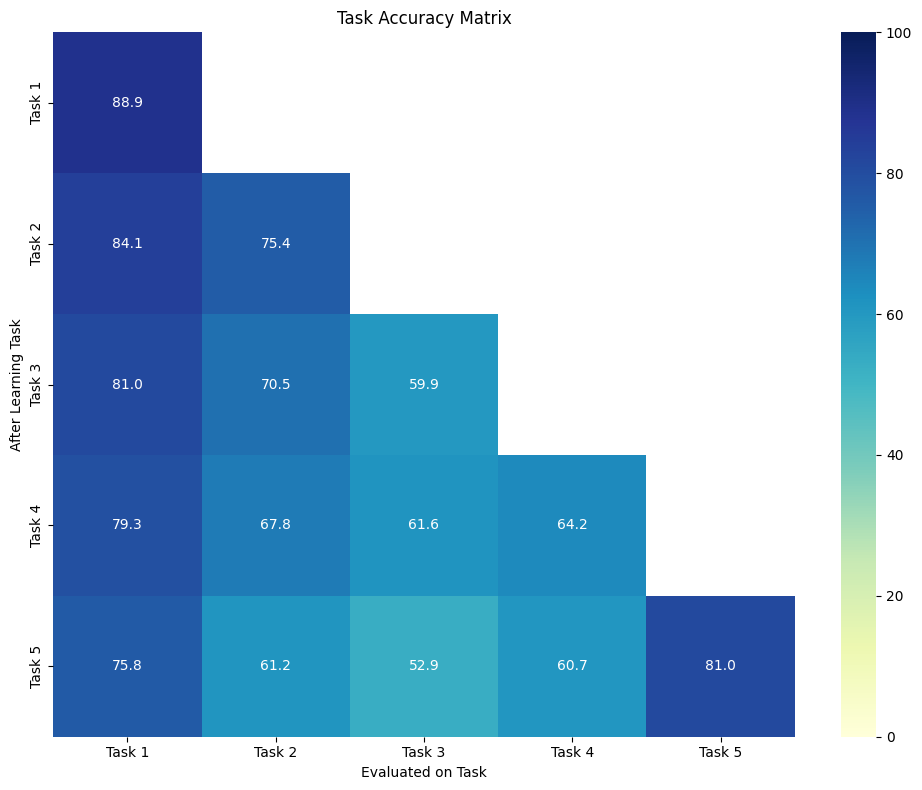

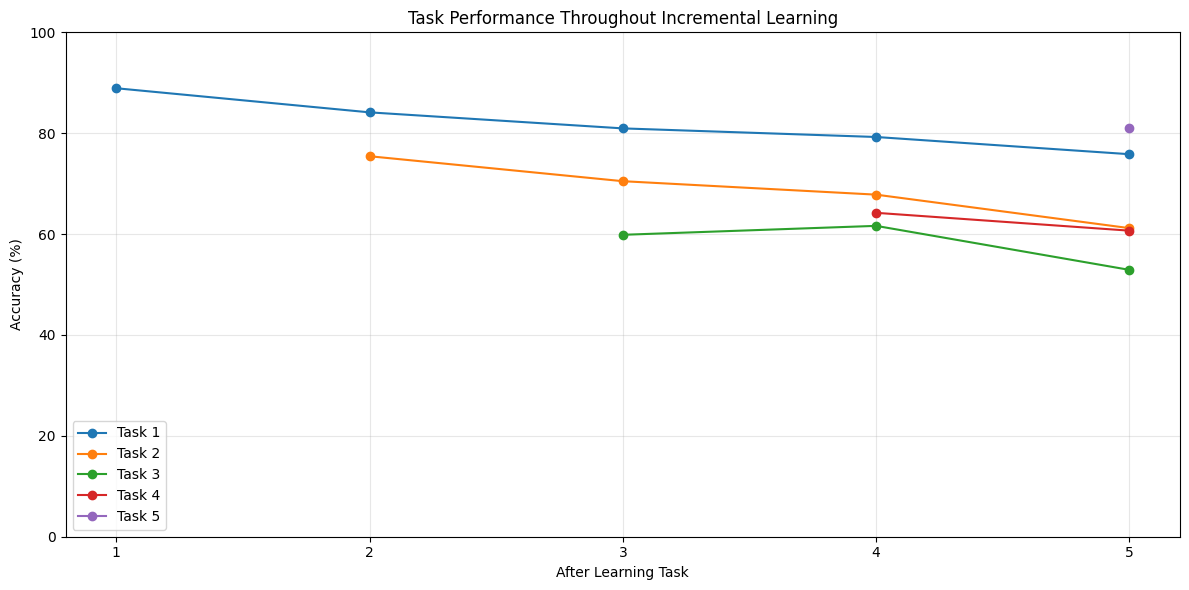

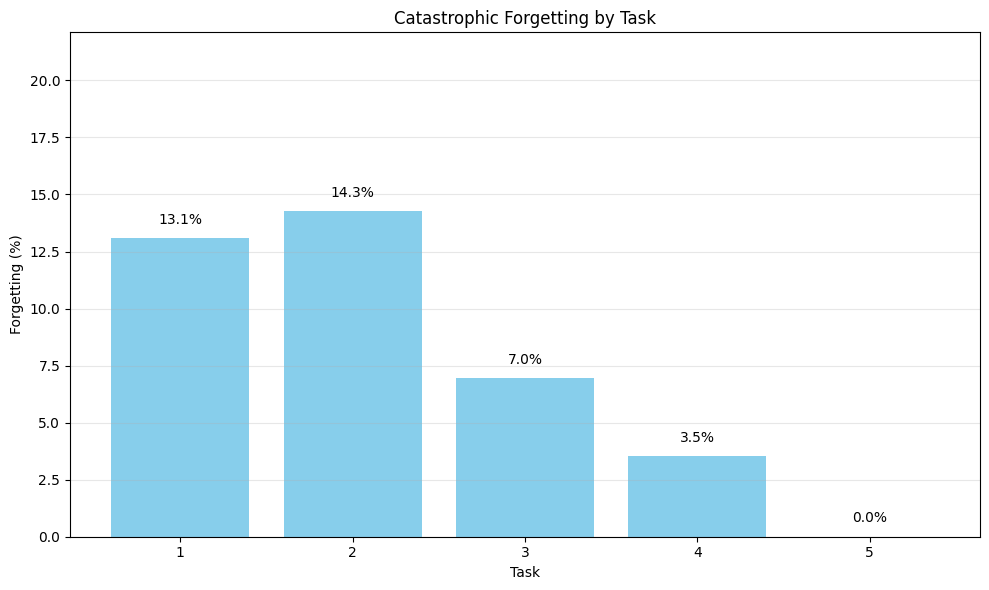

Summary Metrics:
Average Final Accuracy: 66.31%
Average Forgetting: 7.56%
Forgetting by Task: 13.07%, 14.26%, 6.95%, 3.54%, 0.00%


In [19]:
plot_all_metrics(accuracy_matrix)